In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from IPython.display import display, SVG

# Esempio su dato sintetico

Contesto: 
* [Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam) e [Von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann) si sfidano a freccette 🎯
* Von Neumann deve ancora riprendersi dalla sbornia della sera prima 🍺

Vogliamo allenare un modello:
* che impari a riconoscere i tiri effettuati da Von Neumann
* note le coordinate del punto in cui arriva la freccetta

In [2]:
def make_dataset(n_samples: int = 500):
    mean1 = (0, 0)
    cov1 = [(1, 0), (0, 1)]
    g1 = pd.DataFrame(np.random.multivariate_normal(mean1, cov1, n_samples), columns=['x1', 'x2'])
    g1['player'] = 'Von Neumann'

    mean2 = (0, 0)
    cov2 = [(0.25, 0), (0, 0.25)]
    g2 = pd.DataFrame(np.random.multivariate_normal(mean2, cov2, n_samples), columns=['x1', 'x2'])
    g2['player'] = 'Ulam'

    df = pd.concat([g1, g2])

    df['filter'] = np.where((df['player'] == 'Von Neumann') & (df['x1']**2 + df['x2']**2  <= np.random.uniform(1, 1.5, len(df))**2), 1, 0)
    df.drop(df[df['filter']==1].index, inplace=True)
    df.drop('filter', axis=1, inplace=True)
    return shuffle(df).reset_index(drop=True)

In [3]:
df = make_dataset()
df.head()

,x1,x2,player
0,0.227289,0.438581,Ulam
1,0.243029,-0.696059,Ulam
2,0.615473,1.216417,Von Neumann
3,-0.350558,1.154804,Von Neumann
4,0.475411,0.949613,Ulam


Visualizziamo il dataset tramite [seaborn](https://seaborn.pydata.org/), un'altra comoda library di data-visualization basata su matplotlib.

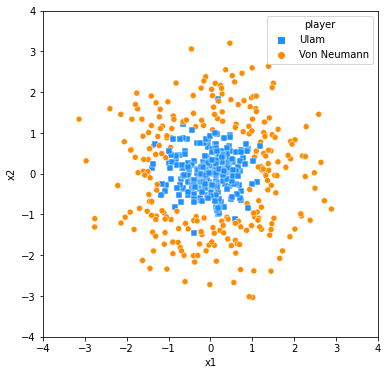

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(
    data=df, 
    x='x1', 
    y='x2', 
    hue='player', 
    style='player', 
    markers={'Von Neumann': 'o', 'Ulam': 's'},
    palette={'Von Neumann': 'darkorange', 'Ulam': 'dodgerblue'}, 
    ax=ax)
ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4));

## Target feature

Dato che il modello deve imparare a riconoscere i tiri di Von Neumann, una scelta naturale è:
* assegnare il valore 1 (classe positiva) ai tiri di Von Neumann
* assegnare il valore 0 (classe negativa) ai tiri di Ulam

### Esercizio
Crea una colonna `'true_class'` nel dataframe che abbia 1 in corrispondenza dei tiri di Von Neumann e 0 in corrispondenza di quelli di Ulam.

In [5]:
df['true_class'] = df['player'].map({'Von Neumann': 1, 'Ulam': 0})
df.head()

,x1,x2,player,true_class
0,0.227289,0.438581,Ulam,0
1,0.243029,-0.696059,Ulam,0
2,0.615473,1.216417,Von Neumann,1
3,-0.350558,1.154804,Von Neumann,1
4,0.475411,0.949613,Ulam,0


## Setup modello

Utilizziamo un Decision Tree (algoritmo introdotto nella lezione precedente sulla regressione).

> **N.B.**: gli alberi decisionali _non_ sono gli unici algoritmi in grado di risolvere task di classificazione.<br>
Per un esempio "visivo" delle alternative disponibili in scikit-learn, approfondire [qui](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py).

Per comodità, abbiamo pronta una funzione per visualizzare le classificazioni del modello.

In [6]:
def plot_classification(df):
    fig, ax = plt.subplots(1, 3, figsize=(21, 6))
    for _ax in ax:
        _ax.set_xlim((-4, 4))
        _ax.set_ylim((-4, 4))    
    sns.scatterplot(data=df, x='x1', y='x2', hue='true_class', palette={0: 'dodgerblue', 1: 'darkorange'}, style='true_class', markers={1: 'o', 0: 's'}, ax=ax[0])
    ax[0].set_title('True class')
    sns.scatterplot(data=df, x='x1', y='x2', hue='pred_class', palette={0: 'dodgerblue', 1: 'darkorange'}, style='pred_class', markers={1: 'o', 0: 's'}, ax=ax[1])
    ax[1].set_title('Predicted class')
    sns.scatterplot(data=df[~df['match']], x='x1', y='x2', color='red', style='match', markers={False: 'x'}, ax=ax[2])
    ax[2].set_title('Wrong prediction')    

### Esercizio

1. Allena su tutto il dataset a disposizione un `DecisionTreeClassifier` che abbia:
    * hyperparameters di default
    * le coordinate come predittori
    * la classe come target feature

    
2. Salva il risultato della classificazione su tutto il dataset in una nuova colonna del dataset `'pred_class'`

3. Utilizza `np.where()` per controllare dove la classificazione coincide con la target feature, e salva il risultato in una nuova colonna del dataset `'match'` 

4. Visualizza il risultato tramite eseguendo la funzione `plot_classification(df)`

In [7]:
from sklearn import tree

In [8]:
model = tree.DecisionTreeClassifier().fit(df[['x1', 'x2']], df['true_class'])
df['pred_class'] = model.predict(df[['x1', 'x2']])
df['match'] = np.where(df['true_class'] == df['pred_class'], True, False)

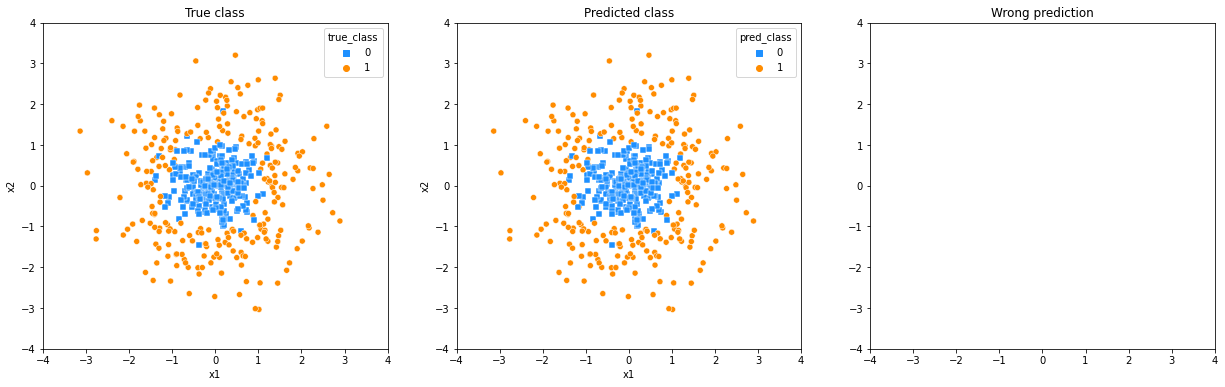

In [9]:
plot_classification(df)

Visualizziamo l'albero (già salvato tramite il seguente codice)

```python
from dtreeviz.trees import dtreeviz

viz = dtreeviz(
    model, 
    df[['x1', 'x2']], 
    df['true_class'],
    target_name='true_class',
    feature_names=['x1', 'x2'],
    class_names=["Ulam", "Von Neumann"],
    colors={'classes': [None, None, ['dodgerblue', 'darkorange']]}
)

viz.save("decision_tree_classifier_complete.svg")
```

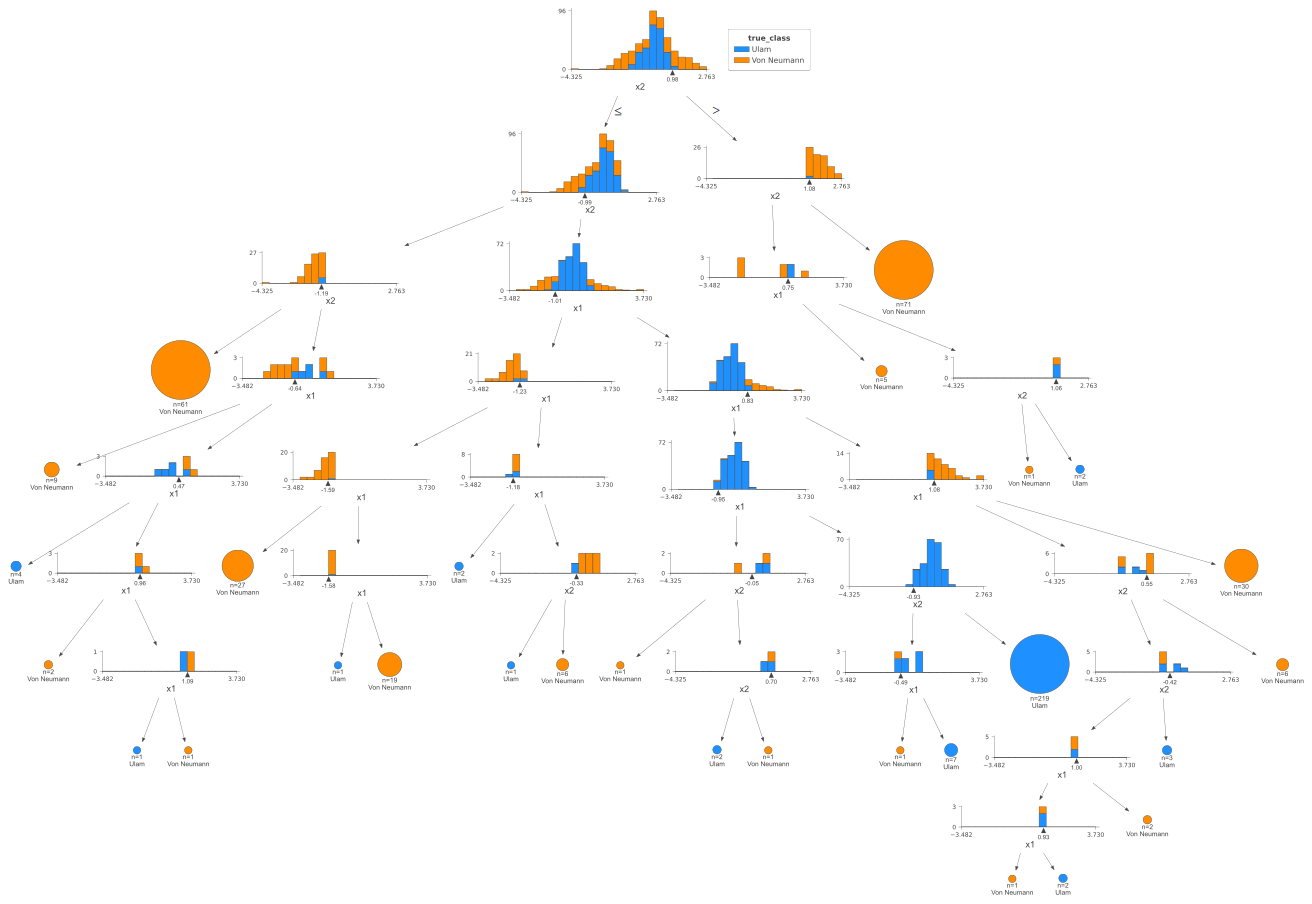

In [10]:
display(SVG('./decision_tree_classifier_complete.svg'))

### Esercizio

Cosa noti circa il modello ottenuto?

Ricicla il codice dell'esercizio precedente per ripetere l'esperimento modificando il parametro `max_depth` e visualizzando nuovamente il risultato.

In [11]:
model = tree.DecisionTreeClassifier(max_depth=3).fit(df[['x1', 'x2']], df['true_class'])
df['pred_class'] = model.predict(df[['x1', 'x2']])
df['match'] = np.where(df['true_class'] == df['pred_class'], True, False)

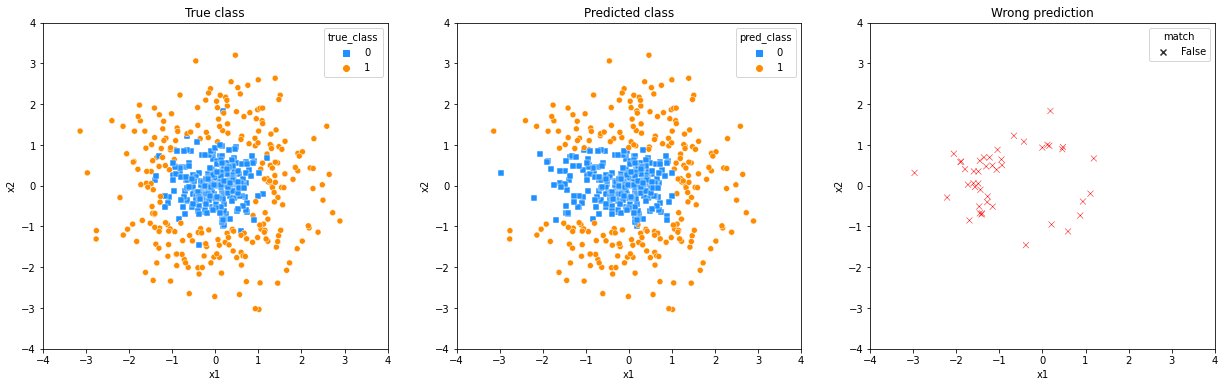

In [12]:
plot_classification(df)

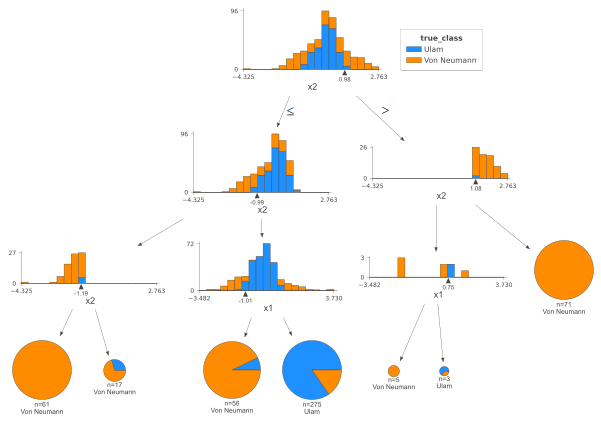

In [13]:
display(SVG('./decision_tree_classifier_3depth.svg'))

## Model evaluation

### Domanda
La visualizzazione precedente mostra gli errori di classificazione del modello. 

* Siamo soddisfatti di _come_ li mostra? 
* L'informazione è sufficiente a capire se il modello ha imparato a riconoscere i tiri di Von Neumann?

### Esercizio

Ricava dal dataset precedente:

* il numero di tiri di Von Neumann correttamente classificati
* il numero di tiri di Ulam correttamente classificati
* il numero di tiri di Ulam erroneamente classificati
* il numero di tiri di Von Neumann erroneamente classificati

In [19]:
df.groupby(['true_class', 'pred_class']).size().unstack()

pred_class,0,1
true_class,,
0,238,13
1,32,219


### Esercizio

Le metriche calcolate nel precedente esercizio sono rispettivamente

* true positives (TP) 
* true negatives (TN) 
* false positives (FP)
* false negatives (FN) 

<br><img src="./classification.png" style="width:35%"><br><br>

Importa da `sklearn.metrics` la metrica `confusion_matrix` e

1. valuta la metrica sul dataset
2. verifica che il risultato coincida con quello calcolato manualmente nell'esercizio precedente

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
confusion_matrix(df['true_class'], df['pred_class'])

array([[238,  13],
       [ 32, 219]], dtype=int64)

E' possibile anche visualizzare in maniera più significativa la matrice di confusione

In [22]:
from sklearn.metrics import plot_confusion_matrix

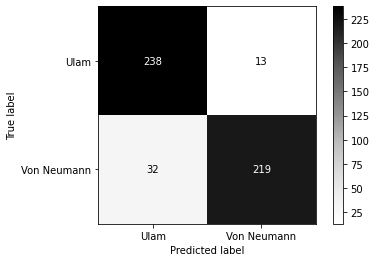

In [23]:
plot_confusion_matrix(
    model, 
    df[['x1', 'x2']], 
    df['true_class'],
    cmap='Greys',
    labels=[0, 1],
    display_labels=['Ulam', 'Von Neumann']
);

### Esercizio

La funzione `plot_confusion_matrix` ha un keyword argument molto utile: `normalize`, che può assumere valore `'true'`, `'pred'` oppure `'all'`.

Fai qualche esperimento normalizzando la matrice di confusione: come cambia la lettura dei risultati?

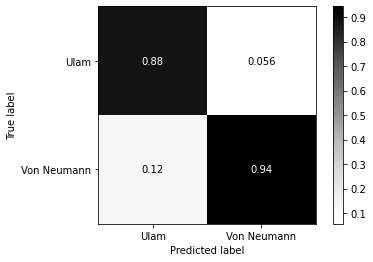

In [24]:
plot_confusion_matrix(
    model, 
    df[['x1', 'x2']], 
    df['true_class'],
    cmap='Greys',
    labels=[0, 1],
    display_labels=['Ulam', 'Von Neumann'],
    normalize='pred'
);

Esistono [_molte_ metriche](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) di valutazione per modelli di classificazione, ma molte di queste possono essere ricavate in maniera semplice dalla matrice di confusione. 

Tra loro citiamo:

* **accuracy** ➜ $\large \frac{TP + TN}{TP + TN + FP + FN}$
> quanti tiri sono stati classificati correttamente rispetto al totale?

* **precision (P)** ➜ $\large \frac{TP}{TP + FP}$
> quanti tiri sono stati classificati correttamente "di Von Neumann" rispetto al totale di tiri _classificati_ "di Von Neumann"?

* **recall (R)** ➜ $\large \frac{TP}{TP + FN}$
> quanti tiri sono stati classificati correttamente "di Von Neumann" rispetto al totale di tiri _effettivamente_ "di Von Neumann"?<br>
nel contesto dei [_test statistici_](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) conosciuta anche come **sensitivity**

* **specificity** ➜ $\large \frac{TN}{TN + FP}$
> quanti tiri sono stati classificati correttamente "di Ulam" rispetto al totale di tiri _effettivamente_ "di Ulam"?<br>

- **f1-score**, [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean#Harmonic_mean_of_two_numbers) di precision e recall ➜ $2\cdot \large \frac{PR}{P + R}$

Ogni metrica può essere utile in determinati contesti a seconda di quale errore tra FP e FN è più interessante misurare.

#### Approfondimento

* un'utile visualizzazione della differenza tra precision e recall è disponibile [qui](https://en.wikipedia.org/wiki/Precision_and_recall)

### Esercizio
Importa da `sklearn.metrics` la metriche `accuracy_score`, `precision_score` e `recall_score`.

Fai qualche esperimento per controllare che i risultati siano coerenti con quelli riportati nella matrice di confusione (ev. normalizzata).


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [26]:
(
    accuracy_score(df['true_class'], df['pred_class']),
    precision_score(df['true_class'], df['pred_class']),
    recall_score(df['true_class'], df['pred_class'])
)

(0.9103585657370518, 0.9439655172413793, 0.8725099601593626)

### Esercizio (BONUS)

Importa da `sklearn.metrics` la metrica `classification_report` e printa il risultato delle principali metriche.

⚠️ sklearn calcola tutte le metriche precedenti _assumendo il punto di vista di ogni classe_ (es. recall e specificity sono visualizzate sotto l'unico nome "recall")

In [27]:
from sklearn.metrics import classification_report

In [28]:
print(classification_report(df['true_class'], df['pred_class']))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       251
           1       0.94      0.87      0.91       251

    accuracy                           0.91       502
   macro avg       0.91      0.91      0.91       502
weighted avg       0.91      0.91      0.91       502



### Approfondimento (BONUS)

La classificazione binaria si può generalizzare in

* **multiclass classification** ➜ task in cui sono presenti $C$ classi con $C>2$ ed ogni sample può appartenere ad una e una sola classe
* **multilabel classification** ➜ task in cui vanno assegnate $M$ label binarie ad ogni sample con $M\in [0, N]$ dove $N$ è il numero di classi
> le $M$ label possono essere pensate come possibili proprietà (presenti/non presenti) di ciascun sample tra loro mutuamente non esclusive<br>
può essere affrontato tramite l'implementazione di $N$ classificatori binari, ciascuno per una label
* **multiclass-multioutput classification** ➜ task in cui ogni sample può ricevere $M$ label, ciascuna delle quali può assumere $C_i>2\;\forall i=1,\dots,M$ valori
> risulta quindi una generalizzazione sia del caso _multilabel_ (perchè considera label non binarie) sia del caso _multiclass_ (perchè considerà più di una classe)

Per approndire, [qui](https://scikit-learn.org/stable/modules/multiclass.html)

### Approfondimento (BONUS)

* [soft vs hard classifiers](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)
* [probability calibration](https://scikit-learn.org/stable/modules/calibration.html)
- [ROC curve](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics)